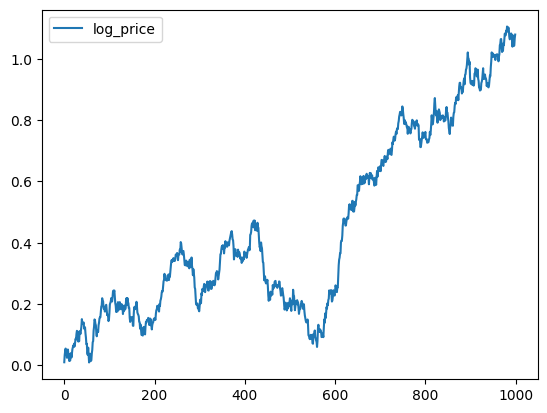

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import kalman

# パラメータ設定
T = 1000  # データの長さ
a = 1  # AR(1)過程のパラメータ
su = 0.01
sw = 0.000001

In [7]:
# データ生成
df = kalman.data_gen(a, su, sw, T, True)

# モデル初期化
kf = KalmanFilter(transition_matrices=[[1, 1], [0, 1]],
                  observation_matrices=[[1, 0]],
                  initial_state_mean=[0, 0],
                  initial_state_covariance=[[1, 0], [0, 1]],
                  observation_covariance=su,
                  transition_covariance=[[0, 0], [0, sw]])

# 予測
df = kalman.pred_confidence_interval(kf, df)

# トレード損益シミュレーション
df = kalman.calc_return(df)

# 可視化
df[["long_ret","short_ret", "both_ret"]].cumsum().plot()
df[["both_ret"]].cumsum().plot()